# More Classification with Scikit-Learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import sklearn as skl
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklmetrics

## Bank Campaign Dataset

We will be using the dataset available from [UCI data repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#), that provides information on the phone campaign run by the bank to see if a customer can be converted to have term deposit at their bank. We will only be using a sample from the data. 

In [3]:
bank_data = pd.read_csv('./data/bank_campaign_small.csv')
bank_data.head()

,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,success
0,30,married,primary,0,1787,0,0,cellular,79,1,-1,0,0
1,33,married,secondary,0,4789,1,1,cellular,220,1,339,4,0
2,35,single,tertiary,0,1350,1,0,cellular,185,1,330,1,0
3,30,married,tertiary,0,1476,1,1,unknown,199,4,-1,0,0
4,59,married,secondary,0,0,1,0,unknown,226,1,-1,0,0


## Handling Categorical Input Variables using `pd.get_dummies()` method

In the previous class, we have deleted the categorical input variables, but you don't have to always delete them. You can convert the cateogrical input variables using `get_dummies()`

In [4]:
bank_data_with_dummies = pd.get_dummies(bank_data)
bank_data_with_dummies.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,success,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,30,0,1787,0,0,79,1,-1,0,0,0,1,0,1,0,0,0,1,0,0
1,33,0,4789,1,1,220,1,339,4,0,0,1,0,0,1,0,0,1,0,0
2,35,0,1350,1,0,185,1,330,1,0,0,0,1,0,0,1,0,1,0,0
3,30,0,1476,1,1,199,4,-1,0,0,0,1,0,0,0,1,0,0,0,1
4,59,0,0,1,0,226,1,-1,0,0,0,1,0,0,1,0,0,0,0,1


### Remove the additional variables introduced by `pd.get_dummies()` method

After removing the additional columns for each categorical variable, we can use this data with dummy columns added as input to various classifiers. 

In [5]:
bank_data_with_dummies.drop(['marital_divorced','education_unknown','contact_unknown'], axis = 1, inplace=True)
bank_data_with_dummies.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,success,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone
0,30,0,1787,0,0,79,1,-1,0,0,1,0,1,0,0,1,0
1,33,0,4789,1,1,220,1,339,4,0,1,0,0,1,0,1,0
2,35,0,1350,1,0,185,1,330,1,0,0,1,0,0,1,1,0
3,30,0,1476,1,1,199,4,-1,0,0,1,0,0,0,1,0,0
4,59,0,0,1,0,226,1,-1,0,0,1,0,0,1,0,0,0


<div class="alert alert-block alert-danger">
<h5>DO NOT SELECT THE PARAMETERS BASED ON TEST DATA </h5>
<p> We have to rather use cross validation techniques discussed below</p>
</div> 


## Cross Validation to Select the Parameters of a Model using `GridSearchCV()`


As we said above, selecting the model parameters has to be done in a cross validation manner. Refer to lecture notes (pdf, pptx) in Sakai for more understanding on cross validation. 

Scikit-Learn provides a wide variety of cross validation techniques, but the most common way is using `GridSearchCV()` method.

**GridSearchCV()** is the process of searching through every possible combination of parameters and selecting the best parameter combination. For example

```python
params = {'max_depth':[2,3],
          'max_features':['auto','log2',None]}
```

Then you have 6 different combination of parameters listed below. Hence, its called grid search. 
* max_depth = 2, max_features = 'auto'
* max_depth = 3, max_features = 'auto'
* max_depth = 2, max_features = 'log2'
* max_depth = 3, max_features = 'log2'
* max_depth = 2, max_features = None
* max_depth = 3, max_features = None

** Finally you can select the best model, based on a metric (usually accuracy).** 


`GridSearchCV()` is very useful method that automates this process of selecting the model with the best set of parameters. The method has four main parameters

* **estimator**: The classifier you want to learn the parameters, LogisticRegression, DecisionTreeClassifier, etc. 
* **param_grid**: Dictionary (dict) of parameters and their values to be searched over. 
* **cv**: How many folds of classification you want to use. Usually 3 for smaller data and 10 for large data. 
* **n_jobs**: Usually you specify this as 1. You can parallelize the process of this search by specifying a value more than 1. **Do not have the n_jobs set to more than 3**, for the first time users. Especially, on a laptop or lab machine or on Vocareum, you will end up stalling the machine and it has to be rebooted. For more experienced students, in the class, check the number of processing cores of the machine before you increase the number.


In [6]:
# Step 1: Split the input variables (X) and outcome variable (Y)

bank_dummies_X = bank_data_with_dummies.drop(['success'], axis = 1)
bank_dummies_Y = bank_data_with_dummies['success']

In [9]:
bank_dummies_Y.value_counts()

0    4000
1     521
Name: success, dtype: int64

In [7]:
# Step 2: Split into training and test data
bank_dum_train_X, bank_dum_test_X, bank_dum_train_Y, bank_dum_test_Y = train_test_split(bank_dummies_X, bank_dummies_Y, 
                                                                                       random_state=37,
                                                                                       train_size = 0.7)

In [8]:
from sklearn.model_selection import GridSearchCV

In [10]:
# For decision tree based classification


# The model you want to set the parameters for
model = DecisionTreeClassifier(class_weight='balanced')

# The parameters to search over for the model
params = {'max_depth':[2,3,4],
          'max_features':['auto','log2',None]}


# Prepare the GridSearch for cross validation
grid_search_dec_tree = GridSearchCV(model, # Note the model is DecisionTreeClassifier as stated above
                                    param_grid=params, # The parameters to search over. 
                                   cv=10, # How many hold out sets to use
                                   n_jobs = 1 # Number of parallel processes to run. 
                                   )

# Do the cross validation on the training data 
grid_search_dec_tree.fit(bank_dum_train_X, bank_dum_train_Y)

# Select the best model

best_dec_tree_cv = grid_search_dec_tree.best_estimator_

# Print the best parameter combination 
print(grid_search_dec_tree.best_params_)

{'max_depth': 3, 'max_features': None}


**Important Notes**
1. Usually for large datasets, the above `GridSearchCV` method takes a lot of time. You might have to make sure, you run with limited set of parameters, before you increase the number of possible values for the parameters. 
2. Everytime you run the GridSearchCV, you might find a different combination of parameters to be the best one. This is another issue with **consistency** of machine learning algorithms. Addressing this is out of the scope for this course. 

0.871039056743
[[1108  112]
 [  63   74]]


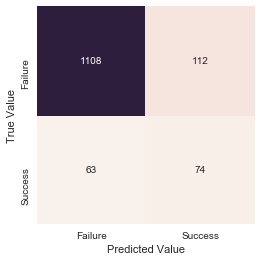

In [11]:
# Finally test the performance of the best model on the test data

bank_dum_pred_Y = best_dec_tree_cv.predict(bank_dum_test_X)

#Print the accuracy 
print(sklmetrics.accuracy_score(bank_dum_test_Y, bank_dum_pred_Y))

conf_mat = sklmetrics.confusion_matrix(bank_dum_test_Y, bank_dum_pred_Y)
print(conf_mat)

# Confusion matrix
sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Failure','Success'], 
                                                            yticklabels = ['Failure','Success'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

## Activity

Learn the parameters of LogisticRegression classifier using `GridSearchCV()` method. 
1. Specify the dictionary of the parameters for LogisticRegression and the values 
2. Set GridSearchCV for LogisticRegression classifier. 
    * Set cv=10
3. Use the training data and fit the GridSearchCV so that it learns the model and the best parameter
4. Select the best model
5. Verify the accuracy and confusion matrix on the testing data. 
6. Present the importance of each characteristic for Logistic Regression using the `plot_feature_importance_coeff` method below. 

In [12]:
# Step 0
model = LogisticRegression(class_weight='balanced')

# Step 1: 
params = {'penalty':['l1','l2'],
          'C': [0.01, 0.1 , 1, 10, 100]}

grid_cv_log_reg = GridSearchCV(model,
                              param_grid = params,
                              cv=10,
                              n_jobs = 1)

grid_cv_log_reg.fit(bank_dum_train_X, bank_dum_train_Y)

best_log_reg = grid_cv_log_reg.best_estimator_

print(grid_cv_log_reg.best_params_)

{'C': 10, 'penalty': 'l1'}


## Metrics for evaluating the performance of classification

Until now, we have been always using `accuracy_score` to verif the performance of the classification on the test data. However, in reality this is not usually the most optimal metric. There are other important metrics to use in real-world, shown below. Again, the discussion on these metrics is out of the scope for this course. 

1. Precision, Recall, F1 Score
2. Area Under the Curve (AUC) of Receiver Operating Characteristic (ROC) curve
3. Area under Precision-Recall Curve
4. Specificity and Sensitivity
5. Positive predictive value
6. ... many more


## Many more classification techniques

We discussed two basic models in this section. However, there are many other classifiers you can use to improve your classification accuracy. Below, I have provided three main classification methods (by no means they are exhaustive)

* MLPClassifier: Multi Layer Perceptron model. This is a very basic model that is a primer to deep learning neural networks. 
    ```python
    from sklearn.neural_network import MLPClassifier
    ```
* GradientBoostClassifier: Learns multiple trees to select the best classifier. 
    ```python
    from sklearn.ensemble import GradientBoostClassifier
    ```
* RandomForestClassifier: Learns multiple trees to select the best classifier. 
    ```python
    from sklearn.ensemble import RandomForestClassifier
    ```


# Clustering with K-Means on a Toy Example

K-Means [visualization](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) is available for you guys to see how k-means works. 

In [13]:
cluster_data = pd.read_csv("./data/clustering_example.csv")
cluster_data.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


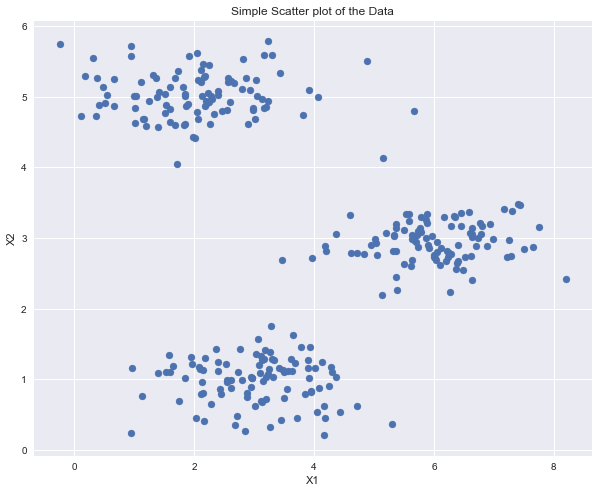

In [14]:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(cluster_data['X1'], cluster_data['X2'])
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Simple Scatter plot of the Data")

In [15]:
# Importing the KMeans clustering method
from sklearn.cluster import KMeans

# Creating the model with number of clusters defined
model = KMeans(n_clusters=3)

# Fitting the model, so that it learns the clusters in the data
model.fit(cluster_data)

# Assingning the cluster numbers to the each data point
cluster_data['cluster'] = model.predict(cluster_data)
cluster_data.head()

,X1,X2,cluster
0,1.842080,4.607572,1
1,5.658583,4.799964,2
2,6.352579,3.290854,2
3,2.904017,4.612204,1
4,3.231979,4.939894,1


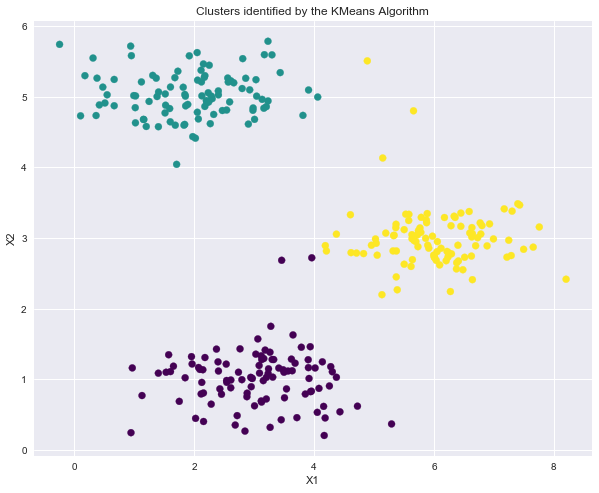

In [16]:
# Plotting the clusters identified by the algorithm
fig, ax = plt.subplots(figsize = (10,8))

# The cluster number is used to color the scatter plot
ax.scatter(cluster_data['X1'], cluster_data['X2'], c=cluster_data['cluster'], cmap = 'viridis')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Clusters identified by the KMeans Algorithm")